Reading /data/lixiang/mem-pattern-recognition/new_bench/parse.res...
['fft', 'gobmk_base.prefetch-riscv', 'perlbench_r_base.prefetch-m64', 'ocean_cp', 'deepsjeng_r_base.prefetch-m64', 'cactusBSSN_r_base.prefetch-m64', 'namd_r_base.prefetch-m64', 'fotonik3d_r_base.prefetch-m64', 'health', 'cholesky', 'treeadd', 'leela_r_base.prefetch-m64', 'voronoi', 'sjeng_base.prefetch-riscv', 'perimeter']
['GemsFDTD_base.prefetch-riscv', 'raytrace', 'ft.A.x', 'zeusmp_base.prefetch-riscv', 'gromacs_base.prefetch-riscv', 'dc.A.x', 'power', 'povray_r_base.prefetch-m64', 'fft', 'deepsjeng_r_base.prefetch-m64', 'em3d', 'perlbench_r_base.prefetch-m64', 'bisort', 'lu.A.x', 'ocean_cp', 'volrend']


/home/lixiang/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/lixiang/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


['bh', 'lbm_r_base.prefetch-m64', 'ua.A.x', 'xz_r_base.prefetch-m64', 'ft.A.x', 'bwaves_r_base.prefetch-m64', 'mst', 'lu_ncb', 'bzip2_base.prefetch-riscv', 'power', 'perimeter', 'is.A.x', 'health', 'mcf_r_base.prefetch-m64', 'deepsjeng_r_base.prefetch-m64', 'radix']


/home/lixiang/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/lixiang/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


['power', 'bzip2_base.prefetch-riscv', 'raytrace', 'bwaves_r_base.prefetch-m64', 'povray_r_base.prefetch-m64', 'cpugcc_r_base.prefetch-m64', 'fft', 'zeusmp_base.prefetch-riscv', 'lu.A.x', 'ocean_ncp', 'xz_r_base.prefetch-m64', 'ldecod_r_base.prefetch-m64', 'health', 'deepsjeng_r_base.prefetch-m64', 'radix', 'volrend']


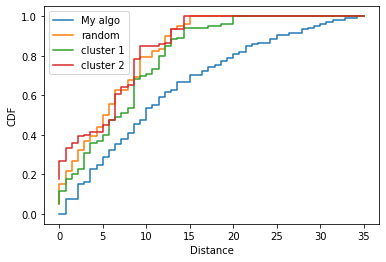

In [25]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
from random import sample, choice
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
K=16
N=65
file="parse.res"
# if sys.argc != 1:
#     print("Usage: ./cluster.py result_file")
#     exit()
# file = sys.argv[1]
if not os.path.isabs(file):
    file = os.path.join(os.getcwd(), file)
print(f"Reading {file}...")

content = open(file)
app = []
X = []
for line in content.readlines():
    tmp = line.strip().split(',')
    app.append(tmp[0])
    tmp=[t[:-1] for t in tmp[1:]]
    X.append(tmp)
X=X[:N]
app=app[:N]


def dist(X,Y):
    sum=0
    for i in range(len(X)):
        sum=(float(X[i])-float(Y[i]))*(float(X[i])-float(Y[i]))
    return math.sqrt(sum)

def BuildGraph(limit):
    edges = pd.DataFrame(columns=['sources','targets'])
    N=len(X)
    for i in range(N):
        for j in range(i+1,N):
            if dist(X[i],X[j])<=limit:
                # print(app[i]+","+app[j])
                edges=edges.append({'sources':app[i],'targets':app[j]},ignore_index=True)
                edges=edges.append({'sources':app[j],'targets':app[i]},ignore_index=True)
    # print(edges)
    G=nx.from_pandas_edgelist(edges,source='sources',target='targets')
    for ap in app:
        if ap not in G.nodes:
            G.add_node(ap)
    return G

fig, ax=plt.subplots()
x=np.linspace(0,35)

def Paint(G,name="a"):
    global ax,x,ans
    ans=ans[:K] 
    print(ans)
    m=len(ans)
    result=[]
    for i in range(m):
        di=0
        for ii in range(N):
            if app[ii]==ans[i]:
                di=ii
                break
        for j in range(i+1,m):
            dj=0
            for jj in range(N):
                if app[jj]==ans[j]:
                    dj=jj
                    break
            result.append(dist(X[di],X[dj]))

    ecdf=sm.distributions.ECDF(result)
    # x=np.linspace(min(result),max(result))
    y=ecdf(x)
    # plt.step(x,y)
    ax.step(x, y, label=name)
    # plt.savefig(f'{name}.png')
    # plt.clf()
    
            
    # color_map = ['red' if node in ans else 'green' for node in G]
    # nx.draw(G,with_labels=True,pos=nx.kamada_kawai_layout(G),node_color=color_map)
    # plt.savefig(f'{name}.png')
    # plt.clf()

def check(limit):
    G=BuildGraph(limit)
    global ans
    ans=nx.maximal_independent_set(G)
    # Paint(G,"paint/"+str(limit))
    Paint(G,"My algo")
    return len(ans)>=K

def check_random(limit):
    G=BuildGraph(limit)
    global ans
    ans=sample(app,K)
    # Paint(G,"paint/"+str(limit)+"_random")
    Paint(G,"random")

def check_cluster(limit):
    G=BuildGraph(limit)
    global ans
    ans=[]
    clf = AgglomerativeClustering(n_clusters=K)
    clf.fit(X, app)
    y = clf.fit_predict(X)
    for k in range(K):
        now_app=[]
        for i in range(N):
            if y[i]==k:
                now_app.append(app[i])
        ans.append(choice(now_app))
    # Paint(G,"paint/"+str(limit)+"_cluster")
    Paint(G,"cluster 1")

    
def check_cluster_2(limit):
    G=BuildGraph(limit)
    global ans
    ans=[]
    clf = AgglomerativeClustering(n_clusters=K//2)
    clf.fit(X, app)
    y = clf.fit_predict(X)
    for k in range(K):
        now_app=[]
        for i in range(N):
            if y[i]==k:
                now_app.append(app[i])
        # ans.append(choice(now_app))
        if len(now_app)>1:
            ans.extend(sample(now_app,2))
    # Paint(G,"paint/"+str(limit)+"_cluster")
    Paint(G,"cluster 2")

check(1.01203125)
check_random(1.01203125)
check_cluster(1.01203125)
check_cluster_2(1.01203125)

# fig.show()
ax.set_ylabel('CDF')
ax.set_xlabel('Distance')
ax.legend(loc="upper left")
fig.savefig("test.png")

# T=2
# Ans=0
# Offset=0.1
# L=0
# R=1000
# while L<=R:
#     M=(L+R)/2.0
#     if check(M):
#         Ans=M
#         L=M+1
#     else:
#         R=M-1

# for t in range(T):
#     L=0
#     R=9
#     now=0
#     while L<=R:
#         M=(L+R)/2.0
#         if check(Ans+Offset*M):
#             now=M
#             L=M+1
#         else:
#             R=M-1
#     Ans=Ans+Offset*now
#     Offset=Offset*0.1

# print(Ans)
# G=BuildGraph(Ans)
# Paint(G)
